In [3]:
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import eurec4a
import metpy
import metpy.calc  as mpcalc
from metpy.units import units as mpunit
from metpy.plots import add_metpy_logo, SkewT
from functools import reduce
fs = 10

In [4]:
cat = eurec4a.get_intake_catalog(use_ipfs=False)

Pick one EUREC4A flight day (e.g. 22.1, 24.1, 28.1, 2.2, 5.2, 9.2, 15.2 are all interesting days) and compare
the vertical thermodynamic and dynamic structures of three consecutive single dropsondes (e.g. from the
Northernmost or Southernmost dropsonde location) with the structures of the associated circle means.
How does the variability and temporal evolution at the different scales compare

# Load HALO flight phase information

In [5]:
meta = eurec4a.get_flight_segments()

segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

segments_by_segment_id = {s["segment_id"]: s for s in segments}
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

circles_Feb02 = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,2)
                 and s["platform_id"] == "HALO"
                ]

print(circles_Feb02)

# We select all dropsondes with the quality flag GOOD from the first circle on February 5
dropsonde_ids = segments_by_segment_id[circles_Feb02[0]]["dropsondes"]["GOOD"]
print(dropsonde_ids)

['HALO-0202_c1', 'HALO-0202_c2', 'HALO-0202_c3', 'HALO-0202_c4', 'HALO-0202_c5', 'HALO-0202_c6']
['HALO-0202_s02', 'HALO-0202_s03', 'HALO-0202_s04', 'HALO-0202_s05', 'HALO-0202_s06', 'HALO-0202_s07', 'HALO-0202_s08', 'HALO-0202_s09', 'HALO-0202_s11', 'HALO-0202_s12']


# Load Level 3 and Level 4 data

In [6]:
ds_l4 = cat.dropsondes.JOANNE.level4.to_dask()
ds_l3 = cat.dropsondes.JOANNE.level3.to_dask()

## Select flight segment from Level 3

In [7]:
mask_sondes_first_circle_Feb02 = reduce(lambda a, b: a | b, [ds_l3.sonde_id==d for d in dropsonde_ids])
ds_l3_circle = ds_l3.isel(sonde_id=mask_sondes_first_circle_Feb02)

In [8]:
ds_l3_circle.sonde_id.values

array(['HALO-0202_s02', 'HALO-0202_s03', 'HALO-0202_s04', 'HALO-0202_s05',
       'HALO-0202_s06', 'HALO-0202_s07', 'HALO-0202_s08', 'HALO-0202_s09',
       'HALO-0202_s11', 'HALO-0202_s12'], dtype=object)

## Select flight segment (circle) from Level 4

In [9]:
choose_day = 'HALO-0202'
ds_l4_circle = ds_l4.where(ds_l4.segment_id=='HALO-0202_c1', drop=True).sel(circle=45)

## Compare individual dropsondes with circle mean

In [10]:
def plot_consecutive_profiles(ds, variables, day, profile_type='sondes', list_profiles=['s02', 's03', 's04'], max_height=None):
    
    '''
    Plot vertical profiles from circle mean and individual dropsondes of specified variables.
    '''
    
    fig, axes = plt.subplots(1, len(variables), figsize=(2*len(variables),4), sharey=True)
    plt.subplots_adjust(top=0.92, bottom=0.06, left=0.05, right=0.95, hspace=0.3, wspace=0.1)
        
        
    for i, var in enumerate(variables):
        
        if profile_type == 'sondes':
            # individual sondes, choose 3
            plt.suptitle(f'Consecutive dropsondes')
            
            ds.sel(sonde_id=day+'_'+list_profiles[0])[var].plot(y='alt', ax=axes[i], c='orange', alpha=1, 
                                                                ylim=(0,max_height), label=day+'_s02')
            ds.sel(sonde_id=day+'_'+list_profiles[1])[var].plot(y='alt', ax=axes[i], c='dodgerblue', alpha=1, 
                                                                ylim=(0,max_height), label=day+'_s07')
            ds.sel(sonde_id=day+'_'+list_profiles[2])[var].plot(y='alt', ax=axes[i], c='red', alpha=1, 
                                                                ylim=(0,max_height), label=day+'_s12')
        elif profile_type == 'circles':
            # circles, choose 3
            plt.suptitle(f'Consecutive circles')

            ds.where(ds.segment_id==day+'_'+list_profiles[0], drop=True)[var].plot(y='alt', ax=axes[i], c='darkorchid', alpha=1, 
                                                                ylim=(0,max_height), label=day+'_c1')
            ds.where(ds.segment_id==day+'_'+list_profiles[1], drop=True)[var].plot(y='alt', ax=axes[i], c='yellowgreen', alpha=1, 
                                                                ylim=(0,max_height), label=day+'_c2')
            ds.where(ds.segment_id==day+'_'+list_profiles[2], drop=True)[var].plot(y='alt', ax=axes[i], c='chocolate', alpha=1, 
                                                                ylim=(0,max_height), label=day+'_c3')

        if i == 0:
            axes[i].set_ylabel('Height [m]')
        else:
            axes[i].set_ylabel('')
            
        axes[i].set_xlabel(f'{var} [{ds[var].units}]')
        axes[i].grid(alpha=0.3)
        axes[i].set_title('')
        
    axes[2].legend(fontsize=fs-4)

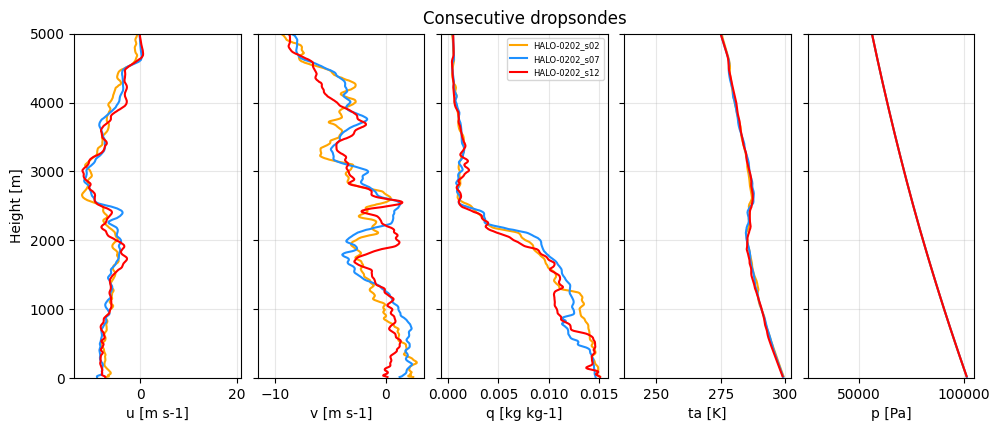

In [11]:
vars_from_dropsondes = ['u', 'v', 'q', 'ta', 'p']#, 'D', 'W', 'omega']

# Plot vertical profiles
plot_consecutive_profiles(ds_l3_circle, vars_from_dropsondes, choose_day, profile_type='sondes', list_profiles=['s02', 's03', 's04'], max_height=5000)

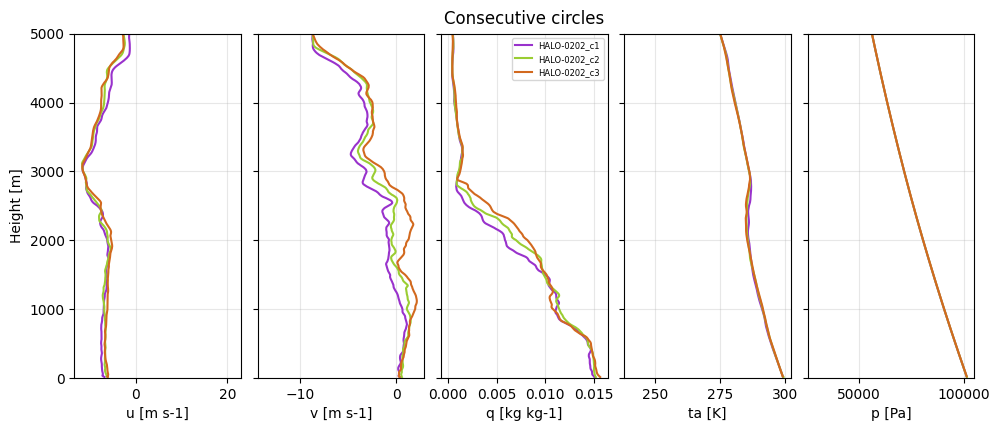

In [12]:
vars_from_dropsondes = ['u', 'v', 'q', 'ta', 'p']#, 'D', 'W', 'omega']

# Plot vertical profiles
plot_consecutive_profiles(ds_l4, vars_from_dropsondes, choose_day, profile_type='circles', list_profiles=['c1', 'c2', 'c3'], max_height=5000)

Discuss variability at different scales

- The profiles corresponding to three consecutive soundings have more variability from each other than the three circles. The spatial and temporal scales are both smaller for the comparison of the three soundings. The three circles, taken as the average of all the soundings within each circle, have very similar vertical profiles. This suggests that there is mostly variability at the small scales, and less so in the mesoscales. From the circles we can see the temporal variability and evolution of the profiles, especially in the meridional velocity and moisture, which both increase as time passes (from C1 to C3). The mesoscale vertical velocity is negative (subsidence. The change in humidity with time is:

$$
\frac{dq}{dt} = -W \frac{dq}{dz}
$$

Since moisture decreases with height, there is a moistening effect with time.

# Skew-T Diagrams

In [23]:
def setup_skew_t(p, T, q, Td, u, v, profile, day):
    # plot skew T 
    skew = SkewT()
    plt.figure(figsize=(9,9))

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p, u, v)

    # Set some better labels than the default
    skew.ax.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
    skew.ax.set_ylabel('Pressure (hPa)')

    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    
    # Calculate LCL height and plot as black dot
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    
    # Calculate LFC height and plot as a blue dot
    lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)
    skew.plot(lfc_pressure, lfc_temperature, 'ko', markerfacecolor='dodgerblue')
    
    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    skew.plot(p, prof, 'k', linewidth=2)
    
    skew.ax.set_ylim(1000, 200)
    skew.ax.set_title(day+'_'+profile, fontsize=fs)
    

def plot_skew_t_from_dropsondes(ds, day, profile_type='sondes', list_profiles=['s02', 's03', 's04']):
        
    if profile_type == 'sondes':
        print('Skew-T for individual soundings...')

        for profile in list_profiles:
            p = ds.sel(sonde_id=day+'_'+profile).p.interpolate_na(dim='alt',fill_value="extrapolate").values * 1e-2 * mpunit.hPa
            T = (ds.sel(sonde_id=day+'_'+profile).ta.interpolate_na(dim='alt',fill_value="extrapolate").values - 273.15) * mpunit.degC
            q = ds.sel(sonde_id=day+'_'+profile).q.interpolate_na(dim='alt',fill_value="extrapolate").values * 1e3 * mpunit('g/kg')
            Td = mpcalc.dewpoint_from_specific_humidity(p, T, q)
            u = ds.sel(sonde_id=day+'_'+profile).u.interpolate_na(dim='alt',fill_value="extrapolate").values * mpunit('m/s')
            v = ds.sel(sonde_id=day+'_'+profile).v.interpolate_na(dim='alt',fill_value="extrapolate").values * mpunit('m/s')
                        
            # plot skew T 
            setup_skew_t(p, T, q, Td, u, v, profile, day)
            
    elif profile_type == 'circles':
        print('Skew-T for circle means...')
        
        for profile in list_profiles:
            p = ds.where(ds.segment_id==day+'_'+profile, drop=True).p.interpolate_na(dim='alt',fill_value="extrapolate").values[0] * 1e-2 * mpunit.hPa
            T = (ds.where(ds.segment_id==day+'_'+profile, drop=True).ta.interpolate_na(dim='alt',fill_value="extrapolate").values - 273.15)[0] * mpunit.degC
            q = ds.where(ds.segment_id==day+'_'+profile, drop=True).q.interpolate_na(dim='alt',fill_value="extrapolate").values[0] * 1e3 * mpunit('g/kg')
            Td = mpcalc.dewpoint_from_specific_humidity(p, T, q)
            u = ds.where(ds.segment_id==day+'_'+profile, drop=True).u.interpolate_na(dim='alt',fill_value="extrapolate").values[0] * mpunit('m/s')
            v = ds.where(ds.segment_id==day+'_'+profile, drop=True).v.interpolate_na(dim='alt',fill_value="extrapolate").values[0] * mpunit('m/s')
           
            # plot skew T 
            setup_skew_t(p, T, q, Td, u, v, profile, day)
            
def calc_params_from_skewT(p, T, Td, sounding_name):
    
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    
    lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)
    
    ccl_pressure, ccl_temperature, T_conv = mpcalc.ccl(p,T,Td)

    el_pressure, el_temperature = metpy.calc.el(p, T, Td)
    
    parcel_profile = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    
    cape, cin = metpy.calc.cape_cin(p, T, Td, parcel_profile)
    
    w_conv = np.sqrt(2*np.abs(cape.magnitude))
    
    print(f'Parameters for {sounding_name}:')
    print('--------------------------------')
    
    print('LCL = ', lcl_pressure)
    print('LFC = ', lfc_pressure)
    print('CCL = ', ccl_pressure)
    print('Convective Temperature = ', T_conv)
    print('Equilibrium Level = ', el_pressure)
    print('CAPE = ', cape)
    print('CIN = ', cin)
    print(r'Convective velocity scale = ', w_conv, 'm/s')
    print('')

### Sondes

In [24]:
list_profiles=['s02', 's03', 's04']

# Print parameters
for profile in list_profiles:
    
    p = ds_l3_circle.sel(sonde_id=choose_day+'_'+profile).p.interpolate_na(dim='alt',fill_value="extrapolate").values * 1e-2 * mpunit.hPa
    T = (ds_l3_circle.sel(sonde_id=choose_day+'_'+profile).ta.interpolate_na(dim='alt',fill_value="extrapolate").values - 273.15) * mpunit.degC
    q = ds_l3_circle.sel(sonde_id=choose_day+'_'+profile).q.interpolate_na(dim='alt',fill_value="extrapolate").values * 1e3 * mpunit('g/kg')
    Td = mpcalc.dewpoint_from_specific_humidity(p, T, q)

    calc_params_from_skewT(p, T, Td, sounding_name = choose_day+'_'+profile)

Parameters for HALO-0202_s02:
--------------------------------
LCL =  936.5248085963777 hectopascal
LFC =  321.24236730192143 hectopascal
CCL =  931.8892211914062 hectopascal
Convective Temperature =  26.831701162486524 degree_Celsius
Equilibrium Level =  (<Quantity(321.119458, 'hectopascal')>, <Quantity(-28.0992745, 'degree_Celsius')>)
CAPE =  -220.32761977285097 joule / kilogram
CIN =  -2.1550863145012378 joule / kilogram
Convective velocity scale =  20.991789812822105 m/s

Parameters for HALO-0202_s03:
--------------------------------
LCL =  929.7485687797911 hectopascal
LFC =  362.2285271553475 hectopascal
CCL =  915.7261962890625 hectopascal
Convective Temperature =  27.333007325309268 degree_Celsius
Equilibrium Level =  (<Quantity(337.523232, 'hectopascal')>, <Quantity(-26.5483845, 'degree_Celsius')>)
CAPE =  -464.4126231443139 joule / kilogram
CIN =  -8.484387699619655 joule / kilogram
Convective velocity scale =  30.476634431784422 m/s

Parameters for HALO-0202_s04:
-----------

Skew-T for individual soundings...


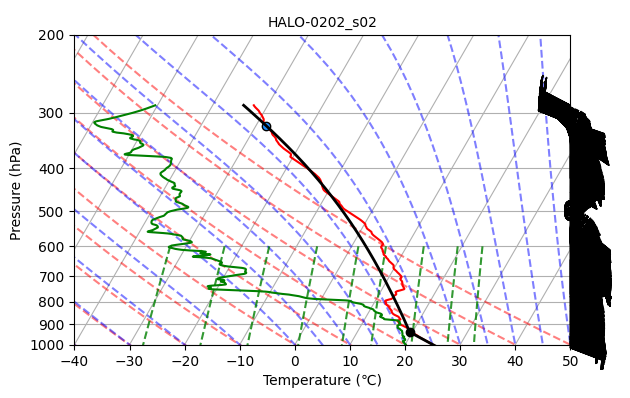

<Figure size 900x900 with 0 Axes>

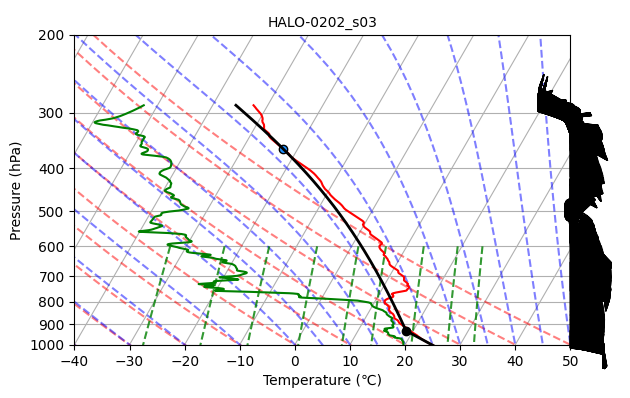

<Figure size 900x900 with 0 Axes>

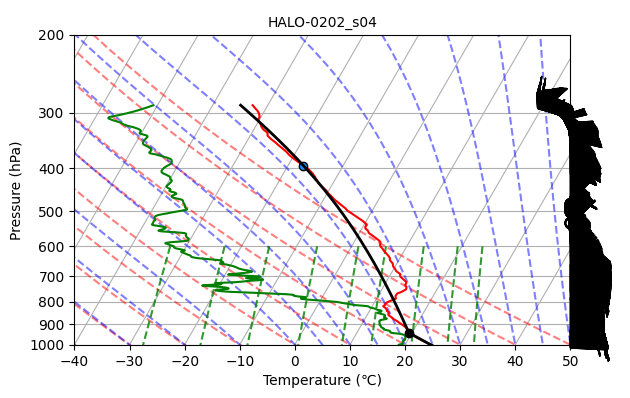

<Figure size 900x900 with 0 Axes>

In [21]:
plot_skew_t_from_dropsondes(ds_l3_circle, choose_day)

### Circles

In [25]:
list_profiles=['c1', 'c2', 'c3']

# Print parameters
for profile in list_profiles:
    
    p = ds_l4.where(ds_l4.segment_id==choose_day+'_'+profile, drop=True).p.interpolate_na(dim='alt',fill_value="extrapolate").values[0] * 1e-2 * mpunit.hPa
    T = (ds_l4.where(ds_l4.segment_id==choose_day+'_'+profile, drop=True).ta.interpolate_na(dim='alt',fill_value="extrapolate").values - 273.15)[0] * mpunit.degC
    q = ds_l4.where(ds_l4.segment_id==choose_day+'_'+profile, drop=True).q.interpolate_na(dim='alt',fill_value="extrapolate").values[0] * 1e3 * mpunit('g/kg')
    Td = mpcalc.dewpoint_from_specific_humidity(p, T, q)

    calc_params_from_skewT(p, T, Td, sounding_name = choose_day+'_'+profile)

/home/m/m300931/.conda/envs/eurec4a/lib/python3.8/site-packages/metpy/calc/thermo.py:1384: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


Parameters for HALO-0202_c1:
--------------------------------
LCL =  934.7115019768569 hectopascal
LFC =  394.152911572044 hectopascal
CCL =  917.9422607421875 hectopascal
Convective Temperature =  27.584724079368982 degree_Celsius
Equilibrium Level =  (<Quantity(344.502002, 'hectopascal')>, <Quantity(-24.6825254, 'degree_Celsius')>)
CAPE =  -357.67755292372294 joule / kilogram
CIN =  -4.882991777525398 joule / kilogram
Convective velocity scale =  26.746123192856302 m/s

Parameters for HALO-0202_c2:
--------------------------------
LCL =  932.4177323143979 hectopascal
LFC =  403.35627320514527 hectopascal
CCL =  919.9132080078125 hectopascal
Convective Temperature =  27.59465009899884 degree_Celsius
Equilibrium Level =  (<Quantity(338.49545, 'hectopascal')>, <Quantity(-25.2192005, 'degree_Celsius')>)
CAPE =  -247.7672402652851 joule / kilogram
CIN =  0 joule / kilogram
Convective velocity scale =  22.26060377731409 m/s

Parameters for HALO-0202_c3:
--------------------------------
LCL

Skew-T for circle means...


/home/m/m300931/.conda/envs/eurec4a/lib/python3.8/site-packages/metpy/calc/thermo.py:1384: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


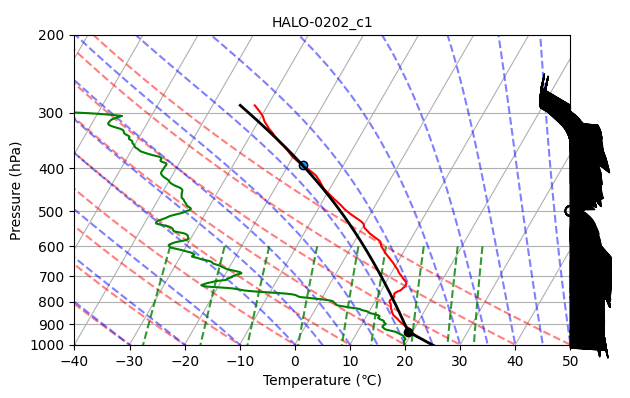

<Figure size 900x900 with 0 Axes>

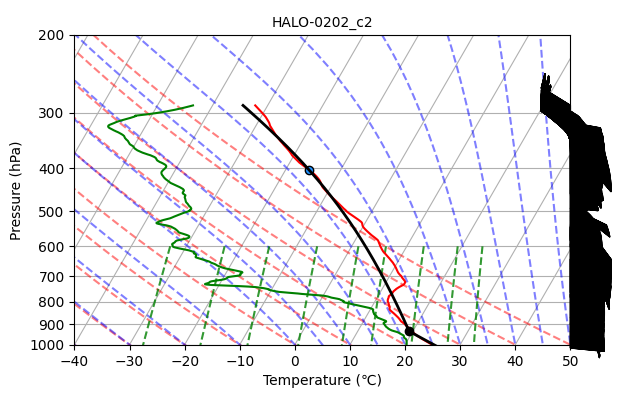

<Figure size 900x900 with 0 Axes>

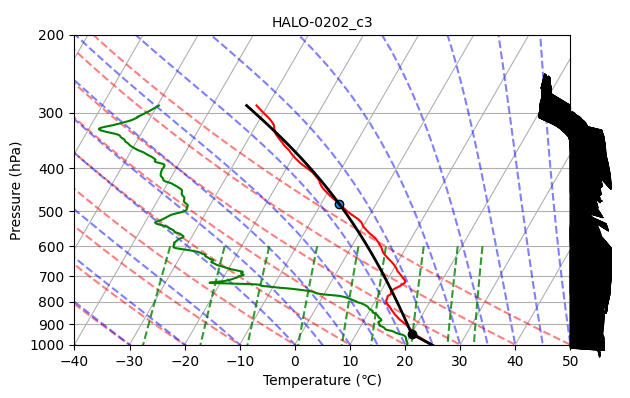

<Figure size 900x900 with 0 Axes>

In [44]:
plot_skew_t_from_dropsondes(ds_l4, choose_day, profile_type='circles', list_profiles=['c1', 'c2', 'c3'])

Speculate on how the different processes could have contributed to the temporal evolution of the trade-wind layer. Apart from the skew-T-derived quantities, you might also want to consider the horizontal wind and mesoscale vertical velocity.



- CAPE measures the amount of buoyant energy avalable as the parcel moves upward, and higher CAPE means a greater instability. Surface buoyancy fluxes (heating or moistening from the ground, for example) can then alter CAPE and lead to changes in the stability, boundary layer depth, and convective velocities. More buoyancy also leads to more turbulence, which is associated with boundary layer growth through mixing.

- Changes in the fluxes also lead to different LCL, CCL, LFC, and convective temperature. Where clouds form also has an impact on the structure of the boundary layer, for example through the exchanges of latent heat from condensation, which adjust the temperature and moisture profiles. Another process that could impact the boundary layer is precipitation, which is associated with convection, unlike just the transition from water vapor to liquid water when a cloud is formed.

- Horizontal wind profiles are associated with shear, which can also lead to instabilities. Horizontal winds can also tell us about the scales of the most relevant convective scales. 

- Vertical velocity can give us information about subsidence or ascending motion, and perhaps indicat how the updrafts and downdrafts are organized.

# Wikipedia Article Topic

I would like to write my Wikipedia article on __cold pools__. This article currently exists but it is not very comprehensive. Some sources are therefore already present in the existing article. I would use the following literature as a starting point to write about cold pools:

1. Zuidema, P., and Coauthors, 2012: On Trade Wind Cumulus Cold Pools. J. Atmos. Sci., 69, 258–280, https://doi.org/10.1175/JAS-D-11-0143.1. 
2. Zuidema, P., Torri, G., Muller, C. et al. A Survey of Precipitation-Induced Atmospheric Cold Pools over Oceans and Their Interactions with the Larger-Scale Environment. Surv Geophys 38, 1283–1305 (2017). https://doi.org/10.1007/s10712-017-9447-x
3. de Szoeke, S. P., E. D. Skyllingstad, P. Zuidema, and A. S. Chandra, 2017: Cold Pools and Their Influence on the Tropical Marine Boundary Layer. J. Atmos. Sci., 74, 1149–1168, https://doi.org/10.1175/JAS-D-16-0264.1. 
4. Drager, A. J., and van den Heever, S. C. (2017), Characterizing convective cold pools, J. Adv. Model. Earth Syst., 9, 1091– 1115, doi:10.1002/2016MS000788. 
5. Romps, D.M. and Jeevanjee, N. (2016), On the sizes and lifetimes of cold pools. Q.J.R. Meteorol. Soc., 142: 1517-1527. https://doi.org/10.1002/qj.2754